<a href="https://colab.research.google.com/github/maorgreshler/Project1_Matan-Maor/blob/main/NN_shared_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive  # Import for Google Drive mounting
drive.mount('/content/drive')  # Mount Google Drive
drive_dir = '/content/drive/My Drive/NN_Models_Shared/' # Our google Drive directory

Mounted at /content/drive


In [ ]:
def train_model(df, input_columns, target_columns, model_name, MLP_structure, num_epochs, batch_size, learning_rate):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    full_name = model_name + '_MLP_' + MLP_structure + '_epochs_' + str(num_epochs) + '_batch_' + str(batch_size) + '_lr_' + str(learning_rate)
    model_dir = drive_dir + full_name + '/'

    input_data = df[input_columns].values
    target_data = df[target_columns].values

    # Scaling
    input_scaler = StandardScaler()
    target_scaler = StandardScaler()
    input_data_scaled = input_scaler.fit_transform(input_data)
    target_data_scaled = target_scaler.fit_transform(target_data)

    # Split the data into train and validation sets
    X_train, X_test, y_train, y_test = train_test_split(input_data_scaled, target_data_scaled, test_size=0.2, random_state=42)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize model, loss function, and optimizer
    model = MLP(input_size=len(input_columns), output_size=len(target_columns)).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    writer = SummaryWriter(log_dir=model_dir) # TensorBoard setup

    # Training loop
    for epoch in range(num_epochs):
        model.train() # set the model to training mode
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            predictions = model(inputs)
            loss = criterion(predictions, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_loss_per_feature = np.zeros(len(target_columns))
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                predictions = model(inputs)
                loss = criterion(predictions, targets)
                val_loss += loss.item()

                # Compute unnormalized loss (Mean Absolute Error) for each feature
                predictions_unnormalized = target_scaler.inverse_transform(predictions.cpu().numpy())
                targets_unnormalized = target_scaler.inverse_transform(targets.cpu().numpy())
                abs_errors = np.abs(predictions_unnormalized - targets_unnormalized)
                val_loss_per_feature += abs_errors.mean(axis=0) # Accumulate the mean error per feature


        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_loss_per_feature /= len(val_loader)  # Average loss per feature
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Log losses to TensorBoard
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Loss/Val_unnormalized_Total', val_loss_per_feature.mean(), epoch)
        for i, feature in enumerate(target_columns):
            writer.add_scalar(f'Loss/Val_unnormalized_{feature}', val_loss_per_feature[i], epoch)

        # Add model graph to TensorBoard (only for the first epoch)
        if epoch == 0:
            dummy_input = torch.randn(1, len(input_columns)).to(device)
            writer.add_graph(model, dummy_input)

    writer.flush()  # Ensure all data is written to TensorBoard
    writer.close()

    # Save the model to Google Drive
    model_path = model_dir + 'model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to Google Drive as {model_name}")

    # Save scalers
    scaler_path = model_dir + 'scalers.pth'
    torch.save({'input_scaler': input_scaler, 'target_scaler': target_scaler}, scaler_path)
    print(f"Scalers saved to: {scaler_path}")

    # Show the training process on TensorBoard
    %load_ext tensorboard
    %tensorboard --logdir="$model_dir"

In [ ]:
# Model Training Main
class MLP(nn.Module): # Define the MLP model!!!!!!!!!!!!!!!!!!!!!!
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    def forward(self, x):
        return self.model(x)

if __name__ == '__main__':
    # Load the csv from google drive
    csv_name = 'Data_1_akcerman_ack.csv' # Choose here csv!!!!!!!!!!!!!!!!!!!!!!
    df = pd.read_csv(drive_dir + csv_name)

    # Define the input and target columns
    input_columns  = ['theta', 'velocity', 'yaw_angle', 'yaw_rate', 'slip_angle', 'front_wheel',
                      'back_wheel', 'acceleration', 'angular_acceleration']  # C to K
    target_columns = ['delta_x_position', 'delta_y_position', 'delta_theta', 'delta_velocity', 'delta_yaw_angle',
                      'delta_yaw_rate', 'delta_slip_angle', 'delta_front_wheel', 'delta_back_wheel']  # L to T

    # Train the model: returns the directory where the model saved
    train_model(df, input_columns, target_columns, model_name="NNWithAckermanPrediction", MLP_structure='256x128x64', num_epochs=150, batch_size=64, learning_rate=0.001) # Modify!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
    # Show a saved training process on TensorBoard
    model_name = 'Tuning3_MLP_256x128x64_epochs_150_batch_64_lr_0.001' # change model name to an existing file in drive!!!!!!!!!!!!!!!!!!!!!!
    model_dir = drive_dir + model_name

    %load_ext tensorboard
    %tensorboard --logdir="$model_dir"

In [ ]:
# Evaluation Mode
class MLP(nn.Module): # must define model architecture exactly as was during training!!!!!!!!!!!!!!!!!!!!!!
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size,256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    def forward(self, x):
        return self.model(x)

# Load the csv from google drive
csv_name = 'check_evaluation.csv' # Choose here csv!!!!!!!!!!!!!!!!!!!!!!

# Define the model path
file_name ='NN_Prediction_MLP_256x128x64_epochs_150_batch_64_lr_0.001' # Modify!!!!!!!!!!!!!!!!!!!!!!
model_path = drive_dir + file_name + '/' + 'model.pth'

# Define the input and target columns as was during training
input_columns  = ['theta', 'velocity', 'yaw_angle', 'yaw_rate', 'slip_angle', 'front_wheel',
                  'back_wheel', 'acceleration', 'angular_acceleration']  # C to K
target_columns = ['delta_x_position', 'delta_y_position', 'delta_theta', 'delta_velocity', 'delta_yaw_angle',
                  'delta_yaw_rate', 'delta_slip_angle', 'delta_front_wheel', 'delta_back_wheel']  # L to T

# Initialize the model structure
model = MLP(input_size=len(input_columns), output_size=len(target_columns))

# Load saved weights
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()  # Set the model to evaluation mode

# Load Input data from csv
df = pd.read_csv(drive_dir + csv_name)
input_data = df[input_columns].values

# Load saved scalers
scaler_path = drive_dir + file_name + '/' + 'scalers.pth'
scalers = torch.load(scaler_path)
input_scaler = scalers['input_scaler']
target_scaler = scalers['target_scaler']

input_data_scaled = input_scaler.transform(input_data)
input_data_scaled_tensor = torch.tensor(input_data_scaled, dtype=torch.float32)

# Perform prediction
with torch.no_grad():  # Disable gradient calculation for inference
    prediction_scaled = model(input_data_scaled_tensor)
    prediction = target_scaler.inverse_transform(prediction_scaled.numpy())

# Show prediction
prediction_df = pd.DataFrame(prediction, columns=target_columns)
print("Predicted Outputs:")
print(prediction_df.head())

<ipython-input-5-3e824a5ca6fb>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x, y, s=sizes, alpha=0.7, edgecolors="w", cmap="viridis")


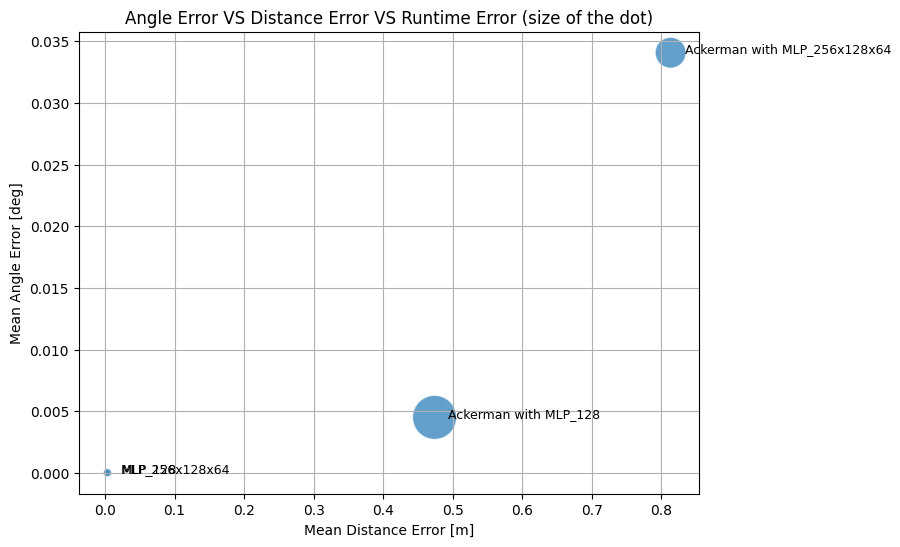

In [5]:
# scatter plot
import numpy as np
import matplotlib.pyplot as plt

# Data for the points
points = [
    {"distance": np.sqrt(0.000873**2 + 0.002712**2), "angle": np.abs(-0.000034), "runtime": 0.07129, "name": "MLP_256x128x64"},
    {"distance": np.sqrt((-0.000875)**2 + 0.003493**2), "angle": np.abs(-0.000027), "runtime":  0.18519, "name": "MLP_128"},
    {"distance": np.sqrt((-0.014737)**2 +  0.813269**2), "angle": np.abs(0.034057), "runtime": 2.48900, "name": "Ackerman with MLP_256x128x64"},
    {"distance": np.sqrt(0.142358**2 + 0.452115**2), "angle": np.abs(-0.004511), "runtime": 5.06459, "name": "Ackerman with MLP_128"},
]

# Extracting values
x = [p["distance"] for p in points]
y = [p["angle"] for p in points]
sizes = [p["runtime"] * 200 for p in points]

# Creating the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, s=sizes, alpha=0.7, edgecolors="w", cmap="viridis")
plt.xlabel("Mean Distance Error [m]")
plt.ylabel("Mean Angle Error [deg]")
plt.title("Angle Error VS Distance Error VS Runtime Error (size of the dot)")
plt.grid(True)

# Adding unique labels to each point
for point in points:
    plt.text(point["distance"] + 0.02, point["angle"], point["name"], fontsize=9)
plt.show()

In [17]:
# Checking that the cv makes sense...
csv_name = 'vehicle_simulation_data_random_test.csv' # Choose here csv!!!!!!!!!!!!!!!!!!!!!!

# Define the input and target columns as was during training
input_columns  = ['theta', 'velocity', 'yaw_angle', 'yaw_rate', 'slip_angle', 'front_wheel',
                  'back_wheel', 'acceleration', 'angular_acceleration']  # C to K
target_columns = ['delta_x_position', 'delta_y_position', 'delta_theta', 'delta_velocity', 'delta_yaw_angle',
                  'delta_yaw_rate', 'delta_slip_angle', 'delta_front_wheel', 'delta_back_wheel']  # L to T

# Load Input data from csv
df = pd.read_csv(drive_dir + csv_name)
input_data = df[input_columns].values
target_data = df[target_columns].values

# Calculate and display the mean values for input and target columns
input_means = df[input_columns].mean()
target_means = df[target_columns[:4]].mean()

print('vehicle_simulation_data_random_test.csv')
print("Mean values of input columns:")
print(input_means)
print("\nMean values of target columns:")
print(target_means)

# The other csv
csv_name = 'Data_1_akcerman_ack.csv' # Choose here csv!!!!!!!!!!!!!!!!!!!!!!

# Load Input data from csv
df = pd.read_csv(drive_dir + csv_name)
input_data = df[input_columns].values
target_data = df[target_columns].values

# Calculate and display the mean values for input and target columns
input_means = df[input_columns].mean()
target_means = df[target_columns[:4]].mean()
print('\nData_1_akcerman_ack.csv')
print("Mean values of input columns:")
print(input_means)
print("\nMean values of target columns:")
print(target_means)

vehicle_simulation_data_random_test.csv
Mean values of input columns:
theta                   0.017040
velocity                9.927751
yaw_angle               0.008911
yaw_rate                0.006547
slip_angle             -0.002443
front_wheel             0.000994
back_wheel             -0.000541
acceleration           -0.054480
angular_acceleration    0.001672
dtype: float64

Mean values of target columns:
delta_x_position   -0.000385
delta_y_position   -0.000497
delta_theta         0.000002
delta_velocity      0.064513
dtype: float64

Data_1_akcerman_ack.csv
Mean values of input columns:
theta                    0.014174
velocity                10.084265
yaw_angle                0.001992
yaw_rate                -0.000115
slip_angle              -0.002562
front_wheel             -0.001293
back_wheel              -0.001536
acceleration             0.064410
angular_acceleration     0.002653
dtype: float64

Mean values of target columns:
delta_x_position     0.014114
delta_y_position 